Case: analytical department at a service alternative to Que faire à Paros. 
1sr task:optimize marketing expenses. 

Data:

- Server logs with data on Y.Afisha visits from January 2017 through December 2018
- Dump file with all orders for the period
- Marketing expenses statistics

Marketing department wants to know: 

- How people use the product
- When they start to buy
- How much money each customer brings
- When they pay off

<a id='return'>



The purpose of the work is profit, which source of income is unprofitable, and which income. The method is court analysis. Concentrations will be calculated in the project, product metrics will also be distributed.

The work consists of:

- [Data preprocessing](#preprocessing)

- [merge early dataset](#df)

- [DAU, WAU and MAU calculation](#metrics)

- [Sessions](#sessions)

- [Retention Rate](#rr)

- [Custom Metrics](#client_beh)
    
- [Average Check](#aov)

- [LTV](#ltv)
    
- [САС, ROMI](#ROMI)

- [Conclusions](#conclusions)


## Usefull Questions

1. Product
    1. How many people use it every day, week, and month?
    2. How many sessions are there per day? (One user might have more than one session.)
    3. What is the length of each session?
    4. How often do users come back?
2. Sales
    1. When do people start buying? (In KPI analysis, we're usually interested in knowing the time that elapses between registration and conversion — when the user becomes a customer. For example, if registration and the first purchase occur on the same day, the user might fall into category Conversion 0d. If the first purchase happens the next day, it will be Conversion 1d. You can use any approach that lets you compare the conversions of different cohorts, so that you can determine which cohort, or marketing channel, is most effective.)
    2. How many orders do they make during a given period of time?
    3. What is the average purchase size?
    4. How much money do they bring? (LTV)
3. Marketing
    1. How much money was spent? Overall/per source/over time 
    2. How much did customer acquisition from each of the sources cost?
    3. How worthwhile where the investments? (ROI)

General Conclusion:  
What sources/platforms to recommend? what metrics to focus on? Why? What do metric values tell us?

#### Data Description
### Description of the data

The `visits***` table (server logs with data on website visits):

- *Uid* — user's unique identifier
- *Device* — user's device
- *Start Ts* — session start date and time
- *End Ts* — session end date and time
- *Source Id* — identifier of the ad source the user came from

All dates in this table are in YYYY-MM-DD format.

The `orders****` table (data on orders):

- *Uid* — unique identifier of the user making an order
- *Buy Ts* — order date and time
- *Revenue* — Y.Afisha's revenue from the order

The `costs****` table (data on marketing expenses):

- source_*id* — ad source identifier
- *dt* — date
- *costs* — expenses on this ad source on this day

# Preprocessing
<a id = #preprocessing>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
visits_ = pd.read_csv("/datasets/visits_log.csv")
orders_ = pd.read_csv("/datasets/orders_log.csv")
costs_ = pd.read_csv("/datasets/costs.csv")

In [3]:
dataset = {
    'Visits': visits_,
    'Orders': orders_,
    'Costs': costs_
}

for x, y in dataset.items():
    print(f'{x}', (list(y.shape)))

Визиты [359400, 5]
Заказы [50415, 3]
Расходы [2542, 3]


In [4]:
for x, y in dataset.items():
    #print(f'{x}', f'{list(y.columns)}\n')
    y.columns = y.columns.str.strip().str.lower().str.replace(' ', '_')

In [5]:
for x, y in dataset.items():
    print(f'{x}: {y.isnull().any().any()}')

Визиты: False
Заказы: False
Расходы: False


In [6]:
for x, y in dataset.items():
    if y.isnull().any().any():
        print(f'{x}', (list(y.shape)),'\n')
        print(f'{y.isnull().sum()}\n')
    else:
        print(f'{x}: Нет пропусков')

Визиты: Нет пропусков
Заказы: Нет пропусков
Расходы: Нет пропусков


Translation

Visits: False

Orders: False

Costs: Fals

Visits: False

Orders: False

Costs: False

In [7]:
for x, y in dataset.items():
    if y.duplicated().any().any():
        print(f'{x}', (list(y.shape)),'\n')
        print(f'{y.isnull().sum()}\n')
    else:
        print(f'{x}: Нет дублей')

Визиты: Нет дублей
Заказы: Нет дублей
Расходы: Нет дублей


Visits: False

Orders: False

Costs: False

In [8]:
for x, y in dataset.items():
    print(f'{x}', y.columns)

Визиты Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')
Заказы Index(['buy_ts', 'revenue', 'uid'], dtype='object')
Расходы Index(['source_id', 'dt', 'costs'], dtype='object')


In [9]:
df = dataset['Визиты'].merge(dataset['Orders'], on = 'uid', how="outer")
df.head(4)

,device,end_ts,source_id,start_ts,uid,buy_ts,revenue
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,NaN,NaN
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,NaN,NaN
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,NaN,NaN
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:25:00,2.33


In [10]:
df.rename(columns = ({'start_ts':'date'}), inplace = True)

In [11]:
date_columns = ['end_ts', 'date', 'buy_ts']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
df.columns

Index(['device', 'end_ts', 'source_id', 'date', 'uid', 'buy_ts', 'revenue'], dtype='object')

<a id='return'>Back to contents</a>

## Merging. Original Dataset
<a id = #df>

In [12]:
df['year'] = df.date.apply(lambda x: x.year)
df['month'] = df.date.apply(lambda x: x.month)
df['day'] = df.date.apply(lambda x: x.day)
df['week'] = df.date.apply(lambda x: x.week)
df['cohort_name'] = df['year'].astype(str) + df['month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)

In [13]:
missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values, percentage], axis=1, keys=['Value', '%']).transpose()

,revenue,buy_ts,cohort_name,week,day,month,year,uid,date,source_id,end_ts,device
Значения,262006.000000,262006.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Процент,25.591197,25.591197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df.sample(5).reset_index() 

,index,device,end_ts,source_id,date,uid,buy_ts,revenue,year,month,day,week,cohort_name
0,757213,desktop,2017-11-24 13:53:00,1,2017-11-24 13:53:00,3855382417537508434,2017-11-24 14:28:00,12.00,2017,11,24,47,201711
1,625799,desktop,2017-12-13 18:20:00,2,2017-12-13 18:20:00,10343016064897450067,2017-12-16 15:57:00,0.06,2017,12,13,50,201712
2,620878,desktop,2017-10-18 16:28:00,4,2017-10-18 16:25:00,2037345392173160982,2017-12-02 21:42:00,0.00,2017,10,18,42,201710
3,820714,desktop,2017-11-06 11:10:00,3,2017-11-06 11:10:00,8220875267394596184,NaT,NaN,2017,11,6,45,201711
4,208184,desktop,2018-01-21 15:26:00,1,2018-01-21 15:24:00,11255648391090536411,NaT,NaN,2018,1,21,3,201801


### Categories


In [15]:
categories = df.device.unique()

In [16]:
df.query('device == "desktop"').describe() 

,source_id,uid,revenue,year,month,day,week
count,897601.000000,8.976010e+05,713192.000000,897601.000000,897601.000000,897601.000000,897601.000000
mean,2.859448,8.110870e+18,9.040895,2017.477771,6.522230,15.982535,26.578723
std,1.825160,4.677638e+18,39.242487,0.499506,3.864763,8.658705,16.818692
min,1.000000,2.977294e+14,0.000000,2017.000000,1.000000,1.000000,1.000000
25%,1.000000,3.644483e+18,1.830000,2017.000000,3.000000,9.000000,10.000000
50%,2.000000,6.948781e+18,3.670000,2017.000000,6.000000,16.000000,24.000000
75%,4.000000,1.192045e+19,7.330000,2018.000000,10.000000,23.000000,43.000000
max,10.000000,1.844668e+19,2633.280000,2018.000000,12.000000,31.000000,52.000000


In [17]:
df.query('device == "touch"').describe()

,source_id,uid,revenue,year,month,day,week
count,126212.000000,1.262120e+05,48615.000000,126212.000000,126212.000000,126212.000000,126212.000000
mean,3.515902,8.939863e+18,10.579314,2017.457540,6.678422,15.916854,27.199688
std,1.914878,5.300635e+18,24.614024,0.498196,3.872599,8.852815,16.843046
min,1.000000,1.186350e+13,0.000000,2017.000000,1.000000,1.000000,1.000000
25%,2.000000,4.505629e+18,1.470000,2017.000000,3.000000,8.000000,11.000000
50%,4.000000,8.701540e+18,3.050000,2017.000000,7.000000,16.000000,27.000000
75%,4.000000,1.363146e+19,8.550000,2018.000000,10.000000,24.000000,44.000000
max,10.000000,1.844656e+19,273.780000,2018.000000,12.000000,31.000000,52.000000


In [18]:
df_device = df.copy()

In [19]:
df_device = pd.Categorical(df_device.device, categories= categories, ordered=True)

Text(0.5, 1.0, 'C какого устройства заходят')

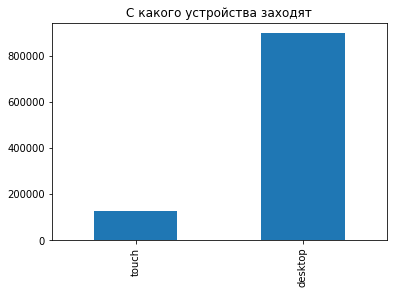

In [20]:
df_device.value_counts().reindex(categories).plot(kind="bar").set_title('Which devise is used')

Inference by Device: More visits recorded from PC. → It is necessary to optimize the landing page, apply adaptive design and promote through social networks of mobile devices, for example, Instagram.

In [21]:
# Finding sources of traffic and their clients distrubution
df.source_id.unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

In [22]:
df.source_id.describe()

count    1.023813e+06
mean     2.940373e+00
std      1.849093e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      1.000000e+01
Name: source_id, dtype: float64

In [23]:
df_source =  df.copy()

In [24]:
sources = pd.Series(df_source.source_id.unique()).sort_values()

Text(0.5, 1.0, 'По какому источнику заходят')

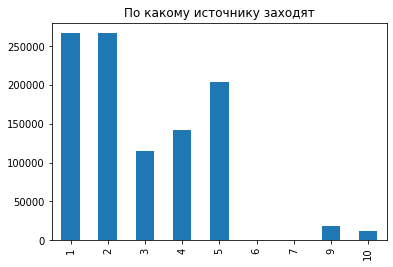

In [25]:
df_source.source_id.value_counts().reindex(sources).plot(kind="bar").set_title('Sources by numbers')

### Time frame - from June 2017 to the end of May 2018
Additionally, we can check the data for compliance with the time interval specified in the condition - whether the sessions go beyond its boundaries. Finding out what devices visitors use and whether it is possible to change the data type in the device column to category. More about this type of data - https://coderlessons.com/tutorials/python-technologies/vyuchit-python-panda/python-pandas-kategoricheskie-dannye Find out what traffic sources we have and how visitors are distributed among them.

In [26]:
df.columns

Index(['device', 'end_ts', 'source_id', 'date', 'uid', 'buy_ts', 'revenue',
       'year', 'month', 'day', 'week', 'cohort_name'],
      dtype='object')

In [27]:
start_timestamp = pd.Timestamp(2017, 6, 1, 0, 0, 0)

In [28]:
start_timestamp = pd.to_datetime(start_timestamp)

In [29]:
df.date.min() < start_timestamp #checking hypothesis

False

In [30]:
deadline = pd.Timestamp(2018, 5, 31, 23, 59, 59)
deadline = pd.to_datetime(deadline)

In [31]:
df.end_ts.max() < deadline #checking hypothesis

False

In [32]:
df = df[(df['date'] > start_timestamp) & (df['date'] <= deadline) & (df['end_ts'] > start_timestamp) & (df['date'] <= deadline) & (df['buy_ts'] > start_timestamp) & (df['buy_ts'] <= deadline)]

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761806 entries, 3 to 1023810
Data columns (total 12 columns):
device         761806 non-null object
end_ts         761806 non-null datetime64[ns]
source_id      761806 non-null int64
date           761806 non-null datetime64[ns]
uid            761806 non-null uint64
buy_ts         761806 non-null datetime64[ns]
revenue        761806 non-null float64
year           761806 non-null int64
month          761806 non-null int64
day            761806 non-null int64
week           761806 non-null int64
cohort_name    761806 non-null object
dtypes: datetime64[ns](3), float64(1), int64(5), object(2), uint64(1)
memory usage: 75.6+ MB


<a id='return'>Back to contents</a>

**Preliminary results. There were no repetitions in the original data, but the temporal data were outside the scope of the study. But each user could make several sessions.
 Connectivity devices—PC and mobile—are unevenly separated. PC has an advantage => you need to make an adaptive layout for mobile devices.
Sources bring traffic in different ways: number 1, 2 and 5 are in the lead.**

## DAU, WAU, MAU
<a id = #metrics>

### Subtasks
--- Calculate DAU, WAU and MAU. Compute the averages of these metrics over the entire period. Display changes in metrics over time on charts;

--- Determine how many times per day users visit the site on average. Build a graph that reflects changes in the metric over time

-- Explore how much time users spend on the site. Find out the duration of a typical user session over the entire period. To choose an appropriate average measure, plot the distribution. The change in session duration over time need not be studied

--- Calculate the Retention Rate using cohort analysis. Show the changes in the metric over time on a graph. Find the average Retention Rate for the second month of the "life" of the cohorts.

In [34]:
print('DAU, WAU, MAU')
dau_mean = df.groupby(['year', 'day']).agg({'uid': 'nunique'}).mean()
wau_mean = df.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()
mau_mean = df.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()

print('DAU', int(dau_mean))
print('WAU', int(wau_mean)) 
print('MAU', int(mau_mean))

2.1.1. Рассчитайте DAU, WAU и MAU
в день 1238
в неделю 1275
в месяц 4686


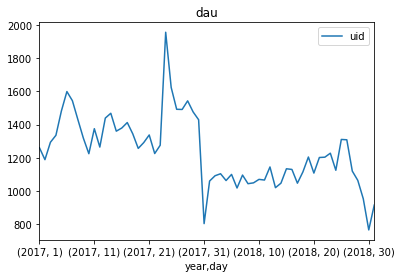

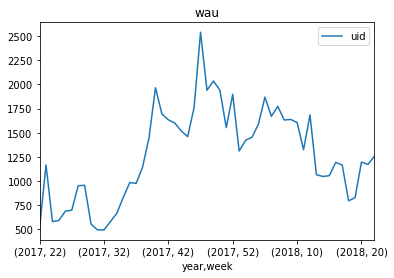

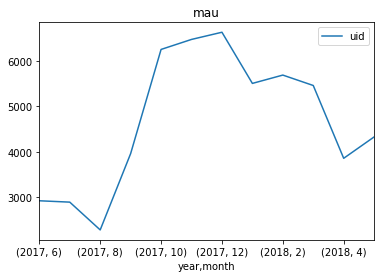

In [35]:
dau = df.groupby(['year', 'day']).agg({'uid': 'nunique'})
wau = df.groupby(['year', 'week']).agg({'uid': 'nunique'})
mau = df.groupby(['year', 'month']).agg({'uid': 'nunique'})


metrics = {'dau': dau, 'wau': wau, 'mau':mau}
#metrics_mean = [dau_mean, wau_mean, mau_mean]
for x, y in metrics.items():
    y.plot().set_title(x)
    #for i in metrics_mean:
        #plt.axhline(i, color='r', linestyle='--'))


**Explanations to the graphs: the number of visitors per day fell on December 31, 2017 - New Year's Eve.
    Growth of visits per week - in 2017
    Growth in gray hair over the year - after falling in August 2017 - growth in 2017 and stabilization until March 2018.**


## Sessions
<a id = 'sessions'>
Subtask: Determine how many times per day users visit the site on average. Plot a graph showing how the metric changes over time

In [37]:
df.columns

Index(['device', 'end_ts', 'source_id', 'date', 'uid', 'buy_ts', 'revenue',
       'year', 'month', 'day', 'week', 'cohort_name'],
      dtype='object')

In [38]:
df_sessions = df.copy() #not to corrupt the original DF

In [39]:
df_sessions['sess_count_mean'] = df_sessions.groupby(['end_ts'])['end_ts'].count().mean()

In [40]:
df_sessions['sess_count_weighted_avg'] = df_sessions['sess_count_mean'] / df_sessions.groupby(by=['cohort_name'])['sess_count_mean'].transform(lambda x: sum(x.unique())) 

In [41]:
df_sessions['sess_count_weighted_avg'].unique() 


array([1.])

Explore how much time users spend on the site. Find out the duration of a typical user session over the entire period. To choose an appropriate average measure, plot the distribution. The change in session duration over time need not be studied;

In [42]:
df['session_duration_mins'] = (
    df['end_ts'] - df['date']
).dt.seconds / 60
print(df['session_duration_mins'].mean())

21.002717139709233


Text(0.5, 1.0, 'Длительность сессий в минутах')

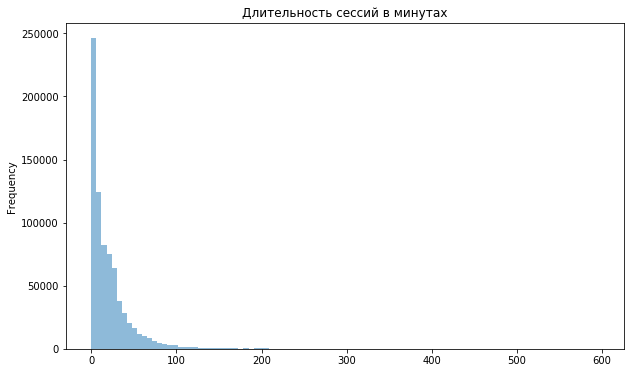

In [43]:
fig = plt.figure(figsize = (10,6))

df['session_duration_mins'].plot.hist(bins = 100, alpha = 0.5, orientation="vertical" ).set_title('Session duration in minutes')



**The distribution is not normal. Better try to visualize differently and calculate quantiles**

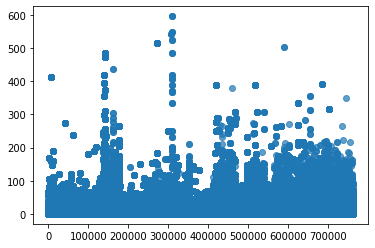

In [44]:
x_values = pd.Series(range(0, len(df['session_duration_mins'])))

plt.scatter(x_values, df['session_duration_mins'], alpha=0.7)

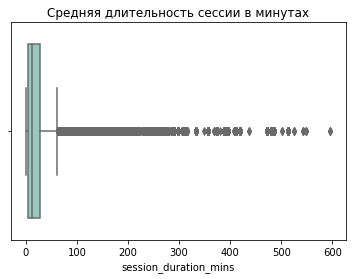

In [45]:
p = sns.boxplot('session_duration_mins',
                 data=df, palette="Set3").set_title('Average duration in minutes')

**The distribution is not normal, let's see the quantiles**
Not done: finding mean value

In [46]:
quantiles = np.percentile(df['session_duration_mins'], [90, 95, 99])

In [47]:
df['session_duration_mins'].std()

28.386429076284198

In [48]:
df['session_duration_mins'].value_counts().sort_values(ascending=False)

1.0      58536
2.0      50243
0.0      39933
3.0      34668
4.0      33718
         ...  
349.0        1
381.0        1
215.0        1
222.0        1
272.0        1
Name: session_duration_mins, Length: 292, dtype: int64

In [49]:
df['sess_mean'] = df.groupby(by=['session_duration_mins'])['uid'].transform('mean')   
df['sess_weighted_avg'] = df['sess_mean']  / df.groupby(by=['cohort_name'])['sess_mean'].transform(lambda x: sum(x.unique())) 

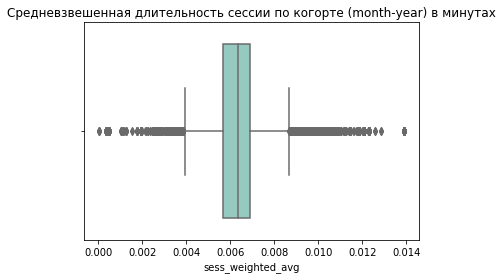

In [50]:
ax = sns.boxplot('sess_weighted_avg',
                 data=df, palette="Set3").set_title('Weighted average session duration by cohort (month-year) in the vicinity')

**Preliminary conclusions. Histogram with a shift to the left. The distribution of session lengths is uneven. The average is 1 session per day, considering cohorts. If for all - 4.5 times. Arithmetic mean of session length - 21 minutes, average calculation - 28 minutes.**

<a id='return'>Back to contents</a>

## Retention Rate
<a id = #rr>

Let's calculate the customer retention and the average for the second month of the life of the cohorts. We need to take data on visits, not purchases.
    
To build a cohort report, we will to determine the date and time of the first session of each user. For convenience of grouping, we will add date and month columns. Then we add information about the first visit to the dataframe with visitors. We count how much time has passed between each session and the first user session. We do a cohort analysis by the number of visitors and calculate the Retention Rate.In addition, we will observe the Retention Rate changes over time (decreases, rises) - on the graph + on the heat map.

In [51]:
rr = df.copy()

In [52]:
rr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761806 entries, 3 to 1023810
Data columns (total 15 columns):
device                   761806 non-null object
end_ts                   761806 non-null datetime64[ns]
source_id                761806 non-null int64
date                     761806 non-null datetime64[ns]
uid                      761806 non-null uint64
buy_ts                   761806 non-null datetime64[ns]
revenue                  761806 non-null float64
year                     761806 non-null int64
month                    761806 non-null int64
day                      761806 non-null int64
week                     761806 non-null int64
cohort_name              761806 non-null object
session_duration_mins    761806 non-null float64
sess_mean                761806 non-null uint64
sess_weighted_avg        761806 non-null float64
dtypes: datetime64[ns](3), float64(3), int64(5), object(2), uint64(2)
memory usage: 93.0+ MB


In [53]:
rr.drop(columns = ['device', 'session_duration_mins', 'sess_mean', 'day', 'week', 'sess_weighted_avg'])

,end_ts,source_id,date,uid,buy_ts,revenue,year,month,cohort_name
3,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:25:00,2.33,2018,5,201805
4,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09 20:25:00,2.33,2018,3,201803
6,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-04 12:46:00,2.44,2017,9,201709
7,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 00:01:00,1.53,2017,9,201709
8,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 19:16:00,1.53,2017,9,201709
...,...,...,...,...,...,...,...,...,...
1023772,2017-12-04 12:50:00,3,2017-12-04 12:42:00,6752020629696526518,2017-12-04 12:46:00,4.15,2017,12,201712
1023776,2017-11-20 23:44:00,4,2017-11-20 23:33:00,11750532881998794555,2017-11-20 23:43:00,3.67,2017,11,201711
1023794,2017-11-29 20:48:00,4,2017-11-29 20:27:00,11202626539189016002,2017-11-29 20:33:00,3.05,2017,11,201711
1023808,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-23 21:16:00,0.49,2018,4,201804


In [54]:
rr.columns

Index(['device', 'end_ts', 'source_id', 'date', 'uid', 'buy_ts', 'revenue',
       'year', 'month', 'day', 'week', 'cohort_name', 'session_duration_mins',
       'sess_mean', 'sess_weighted_avg'],
      dtype='object')

In [55]:
rr['difference'] = rr['end_ts'].max() - rr['date'] 

In [56]:
rr['end_month'] = rr['end_ts'].apply(lambda x: x.strftime('%m'))

In [57]:
grouped_by_cohort = rr.groupby(['cohort_name'], as_index=False).agg({'uid': 'nunique',
                                                             'end_ts': 'last',
                                                            'date': 'first',
                                                           'difference': 'min'
                                                                           }).sort_values(by='difference', ascending = False)

In [58]:
cohort_lifespan = grouped_by_cohort[['cohort_name', 'uid', 'difference']]

In [59]:
cohort_lifespan

,cohort_name,uid,difference
0,201706,2923,335 days 00:14:00
1,201707,2893,304 days 01:14:00
2,201708,2282,273 days 00:22:00
3,201709,3960,243 days 00:16:00
4,201710,6251,212 days 00:16:00
5,201711,6471,182 days 00:14:00
6,201712,6629,151 days 00:17:00
7,201801,5504,120 days 00:15:00
8,201802,5687,92 days 00:22:00
9,201803,5458,62 days 14:44:00


In [60]:
retention_rate = []

In [61]:
for i in range(0, 11):
    retention_rate.append((((cohort_lifespan['uid'][i+1] - cohort_lifespan['uid'][i]) /
  cohort_lifespan['uid'][i]) * 100).round())

In [62]:
#retention_rate = pd.DataFrame(retention_rate)
#retention_rate.columns = ['rr']

In [63]:
s1 = pd.Series(retention_rate)

In [64]:
s2 = cohort_lifespan['cohort_name']

In [65]:
retention_rate_to_plot = pd.concat([s1, s2], axis=1).dropna()

In [66]:
retention_rate_to_plot.columns = ['retention', 'cohort']

In [67]:
retention_rate_to_plot

,retention,cohort
0,-1.0,201706
1,-21.0,201707
2,74.0,201708
3,58.0,201709
4,4.0,201710
5,2.0,201711
6,-17.0,201712
7,3.0,201801
8,-4.0,201802
9,-29.0,201803


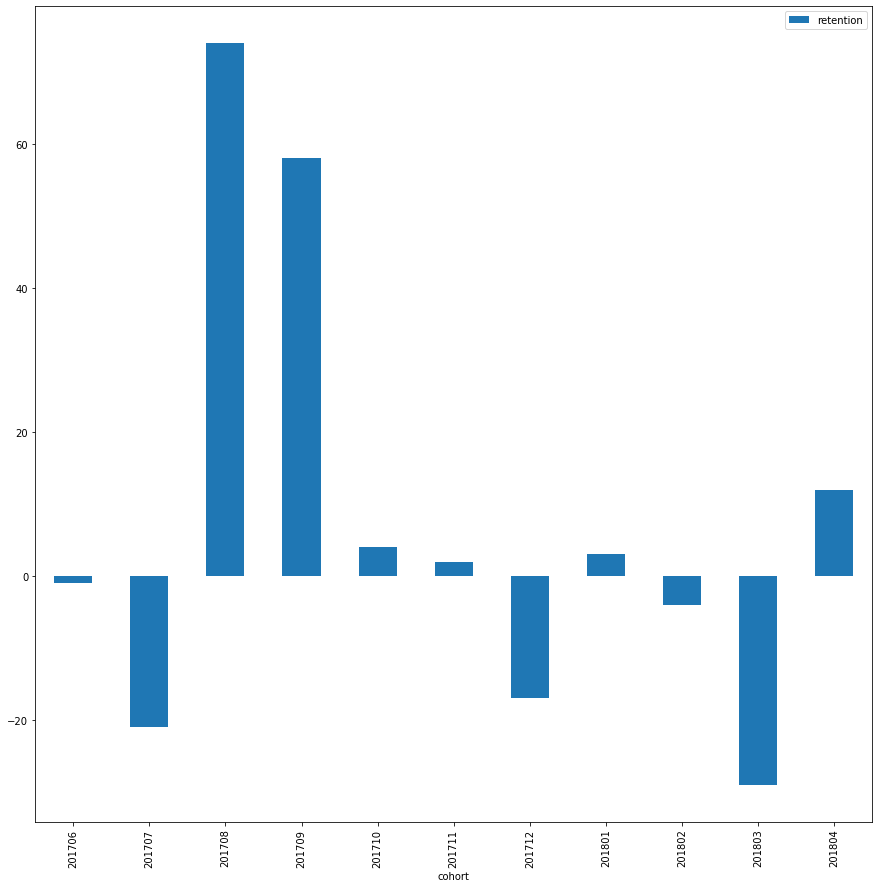

In [68]:
retention_rate_to_plot.plot(kind='bar', x = 'cohort', y = 'retention', figsize = (15,15))


**The graph shows positive and negative retention rates. August and September 2018 cohorts perform best**

In [69]:
retention_rate_to_plot['retention'].mean()

7.363636363636363

In [70]:
cohort_lifespan_to_plot = cohort_lifespan.sort_values(by = 'cohort_name').fillna('0')

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:253: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  data = data.fillna(fillna)


Text(0.5, 1.0, 'Длительность когорт')

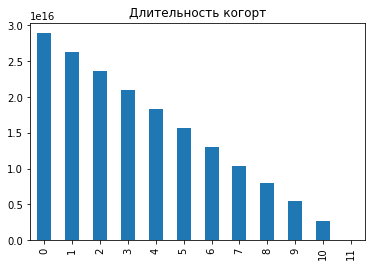

In [71]:
cohort_lifespan_to_plot['difference'].plot(kind = 'bar').set_title('Длительность когорт')

In [72]:
print(cohort_lifespan.mean(), cohort_lifespan.max())

cohort_name          1.68089e+70
uid                      4686.83
difference     167 days 03:34:00
dtype: object cohort_name               201805
uid                         6629
difference     335 days 00:14:00
dtype: object



**Preliminary conclusion
Average cohort duration: 167 days, maximum 335.**


<a id='return'>Back to contents</a>

## Users metrics
<a id = #client_beh>

Subtasks: we will find how long it takes on average from the moment you first visit a site to making a purchase. Using cohort analysis or another method, we will calculate the average number of purchases per customer over a given period, such as 6 months.

### Distribution of time from the first entrance to the site to the purchase

In [73]:
df_purchases = df.copy()

In [74]:
df_purchases

,device,end_ts,source_id,date,uid,buy_ts,revenue,year,month,day,week,cohort_name,session_duration_mins,sess_mean,sess_weighted_avg
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:25:00,2.33,2018,5,20,20,201805,24.0,7678364235770217472,0.006509
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09 20:25:00,2.33,2018,3,9,10,201803,28.0,7631815818556122112,0.006164
6,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-04 12:46:00,2.44,2017,9,3,35,201709,1.0,7807900956213769216,0.007391
7,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 00:01:00,1.53,2017,9,3,35,201709,1.0,7807900956213769216,0.007391
8,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 19:16:00,1.53,2017,9,3,35,201709,1.0,7807900956213769216,0.007391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023772,desktop,2017-12-04 12:50:00,3,2017-12-04 12:42:00,6752020629696526518,2017-12-04 12:46:00,4.15,2017,12,4,49,201712,8.0,7486737539215860736,0.005324
1023776,desktop,2017-11-20 23:44:00,4,2017-11-20 23:33:00,11750532881998794555,2017-11-20 23:43:00,3.67,2017,11,20,47,201711,11.0,7866003394987435008,0.004986
1023794,touch,2017-11-29 20:48:00,4,2017-11-29 20:27:00,11202626539189016002,2017-11-29 20:33:00,3.05,2017,11,29,48,201711,21.0,7548531982666362880,0.004785
1023808,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-23 21:16:00,0.49,2018,4,23,17,201804,8.0,7486737539215860736,0.006401


In [75]:
#def difference(start_ts, buy_ts):
    #df[buy_ts] - df[start_ts]
    #return difference

In [76]:
df_purchases['buy_ts'] = pd.to_datetime(df_purchases['buy_ts'],format='%Y%m%d')
df_purchases['date'] = pd.to_datetime(df_purchases['date'],format='%Y%m%d')

In [77]:
df_purchases = df_purchases.groupby(['uid'])[['buy_ts', 'date']].agg('first')
df_purchases['difference'] = df_purchases['buy_ts'] - df_purchases['date']

In [78]:
df_purchases['difference']

uid
313578113262317        -67 days +04:28:00
1575281904278712          0 days 00:00:00
2429014661409475          0 days 01:19:00
2464366381792757          0 days 19:44:00
2551852515556206        -1 days +22:52:00
                              ...        
18445147675727495770     95 days 19:33:00
18445407535914413204      0 days 00:07:00
18445601152732270159      0 days 01:50:00
18446156210226471712    103 days 09:33:00
18446167067214817906      0 days 00:11:00
Name: difference, Length: 36522, dtype: timedelta64[ns]

In [79]:
df_purchases['difference'].mean()

Timedelta('-2 days +07:15:18.915722')

In [80]:
df_purchases['difference'].quantile([0.9, 0.95])

0.90          10 days 04:05:36
0.95   60 days 03:49:50.999999
Name: difference, dtype: timedelta64[ns]

In [81]:
x_values = pd.Series(range(0, len(df_purchases['difference'])))

Text(0.5, 1.0, 'Распределение: от времени визита до покупки')

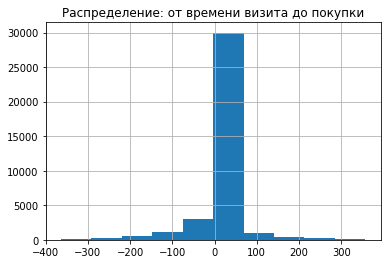

In [82]:
df_purchases['difference'].dt.days.hist().set_title('distribution of time from the first entrance to the site to the purchase')

**Most people need between 10 days and 2 months to make a purchase decision. Any purchases without visiting the site?**

### Average number of orders over 6 months

* Let's build a corporate report on the orders.
* Find the number of buyers in each cohort.
* Adding information about purchases for the first month.
* Calculate the age of each cohort.
* Added to the quarterly report is the number of customers in each cohort and limits the number of orders per customer.
* Building an enlarged cohort report showing the cumulative number of purchases per customer.
* We calculate the average number of purchases per user.

In [83]:
rr['difference_sess'] = rr['buy_ts'] - rr['date']

In [84]:
half_year_filter = rr['difference_sess'] <= '185 days'

In [85]:
half_year_orders = rr[half_year_filter]

In [86]:
cohorts2 = half_year_orders.groupby(['uid','buy_ts'])['buy_ts'].agg('count')

In [87]:
cohorts2.mean()

14.514756581176142

**During six months, an average of 14 visits. Ponder 2 months on average**

In [88]:
df.columns

Index(['device', 'end_ts', 'source_id', 'date', 'uid', 'buy_ts', 'revenue',
       'year', 'month', 'day', 'week', 'cohort_name', 'session_duration_mins',
       'sess_mean', 'sess_weighted_avg'],
      dtype='object')

In [89]:
df_mean_purchases = (
    df.copy().drop(['day', 'week', 'cohort_name', 'session_duration_mins',
       'sess_mean', 'sess_weighted_avg'], axis=1)
    .groupby('uid', as_index=False)
    .agg({'buy_ts': ('first','nunique')})
)

In [90]:
df_mean_purchases.columns

MultiIndex([(   'uid',        ''),
            ('buy_ts',   'first'),
            ('buy_ts', 'nunique')],
           )

In [91]:
df_mean_purchases['1_purchase_month'] = df_mean_purchases[('buy_ts',   'first')]

In [92]:
df_mean_purchases['cohort_name2'] = df_mean_purchases['1_purchase_month'].apply(lambda x: (x.year, x.month))

In [93]:
df_mean_purchases.columns = ['uid', 'first_buy_ts', 'purchase', 'purchase_month', 'cohort_name2'
                            ]

In [94]:
cohort_size = df_mean_purchases.groupby(['cohort_name2'])['uid'].count()

In [95]:
df_mean_purchases['purchase_month'] = df_mean_purchases['purchase_month'].apply(lambda x: x.month)
df_mean_purchases['first_buy_ts'] = df_mean_purchases['first_buy_ts'].apply(lambda x: x.month)

In [96]:

df_mean_purchases.groupby(['first_buy_ts', 'uid'])['purchase'].agg('nunique')

first_buy_ts  uid                 
1             313578113262317         1
              2464366381792757        1
              4808417689019433        1
              12436904862559956       1
              21801295586117262       1
                                     ..
12            18412924851823794261    1
              18413086104342190305    1
              18417867151172617378    1
              18422020045287977498    1
              18433282115640022096    1
Name: purchase, Length: 36522, dtype: int64

In [97]:

df_mean_purchases.groupby(['cohort_name2'])['purchase_month'].agg({'last'})

,last
cohort_name2,
"(2017, 6)",6
"(2017, 7)",7
"(2017, 8)",8
"(2017, 9)",9
"(2017, 10)",10
"(2017, 11)",11
"(2017, 12)",12
"(2018, 1)",1
"(2018, 2)",2


In [98]:
df_mean_purchases.groupby(['cohort_name2'])['uid'].agg({'count'})

,count
cohort_name2,
"(2017, 6)",2023
"(2017, 7)",1923
"(2017, 8)",1370
"(2017, 9)",2581
"(2017, 10)",4340
"(2017, 11)",4081
"(2017, 12)",4383
"(2018, 1)",3373
"(2018, 2)",3651


In [99]:
df_mean_purchases['purchase_month'] 

0         1
1         6
2        10
3         1
4        11
         ..
36517    11
36518     9
36519     3
36520     2
36521    10
Name: purchase_month, Length: 36522, dtype: int64

In [100]:

cohorts = df_mean_purchases.copy().groupby(['cohort_name2','uid'])['purchase'].\
agg({'purchase':'sum', 'purchase_month': 'count'})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


In [101]:
cohorts.groupby(['cohort_name2'])['purchase'].mean()

cohort_name2
(2017, 6)     2.193772
(2017, 7)     1.513261
(2017, 8)     1.597080
(2017, 9)     1.502518
(2017, 10)    1.383641
(2017, 11)    1.445724
(2017, 12)    1.344741
(2018, 1)     1.277201
(2018, 2)     1.224322
(2018, 3)     1.269176
(2018, 4)     1.181898
(2018, 5)     1.087349
Name: purchase, dtype: float64


**Average purchases per customer: 1.4**

<a id='return'> Back to contents </a>

# AOV
<a id = #aov>


We'll calculate the average bill by grouping by time of purchase and build a graph that reflects changes in the metric over time

In [102]:
df_aov = df.copy()

In [103]:
df_aov

,device,end_ts,source_id,date,uid,buy_ts,revenue,year,month,day,week,cohort_name,session_duration_mins,sess_mean,sess_weighted_avg
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:25:00,2.33,2018,5,20,20,201805,24.0,7678364235770217472,0.006509
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09 20:25:00,2.33,2018,3,9,10,201803,28.0,7631815818556122112,0.006164
6,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-04 12:46:00,2.44,2017,9,3,35,201709,1.0,7807900956213769216,0.007391
7,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 00:01:00,1.53,2017,9,3,35,201709,1.0,7807900956213769216,0.007391
8,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 19:16:00,1.53,2017,9,3,35,201709,1.0,7807900956213769216,0.007391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023772,desktop,2017-12-04 12:50:00,3,2017-12-04 12:42:00,6752020629696526518,2017-12-04 12:46:00,4.15,2017,12,4,49,201712,8.0,7486737539215860736,0.005324
1023776,desktop,2017-11-20 23:44:00,4,2017-11-20 23:33:00,11750532881998794555,2017-11-20 23:43:00,3.67,2017,11,20,47,201711,11.0,7866003394987435008,0.004986
1023794,touch,2017-11-29 20:48:00,4,2017-11-29 20:27:00,11202626539189016002,2017-11-29 20:33:00,3.05,2017,11,29,48,201711,21.0,7548531982666362880,0.004785
1023808,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-23 21:16:00,0.49,2018,4,23,17,201804,8.0,7486737539215860736,0.006401


In [104]:
first_sessions = visits_.groupby(['uid']).agg({'start_ts':'min', 'source_id':'first'})
first_sessions.columns = ['1st_activity', '1st_source']

In [105]:
first_orders = orders_.groupby(['uid']).agg({'buy_ts':'min'})
first_orders.columns = ['1st_purch_ts']
first_orders = first_orders.join(first_sessions,on='uid')

In [106]:
orders = orders_.join(first_orders, on='uid')

orders['1st_purchase_month'] = orders['1st_purch_ts'].astype('datetime64[M]')
orders['1st_session_month'] = orders['1st_activity'].astype('datetime64[M]')
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')

In [107]:
orders

,buy_ts,revenue,uid,1st_purch_ts,1st_activity,1st_source,1st_purchase_month,1st_session_month,purchase_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,1,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,2,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,2,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,2,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,3,2017-06-01,2017-06-01,2017-06-01
...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-31 09:11:00,4,2018-05-01,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-31 23:05:00,10,2018-05-01,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-31 23:52:00,3,2018-05-01,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2017-10-23 12:32:00,4,2018-05-01,2017-10-01,2018-05-01


In [108]:
orders['lifetime'] = ((orders['1st_purchase_month'] - orders['1st_session_month']) / np.timedelta64(1, 'M')).round().astype('int')
orders['lifetime'] += 1

In [109]:
orders_grouped_by_cohorts = orders.groupby(['1st_purchase_month', 'lifetime']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
orders_grouped_by_cohorts.columns = ['1st_session_month', 'lifetime', 'revenue', 'n_users']
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['n_users']

df_aov = orders_grouped_by_cohorts.pivot_table(index = '1st_session_month', columns = 'lifetime', values = 'revenue_per_user', aggfunc = 'mean')


Text(0.5, 1, 'Доход каждого месяца жизни когорты')

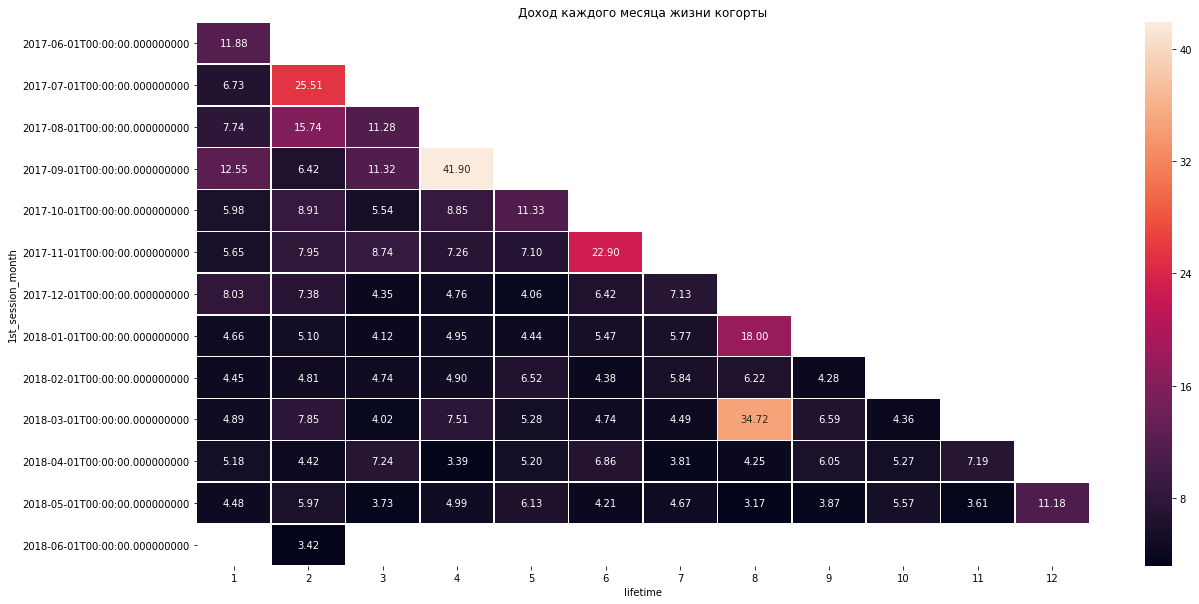

In [110]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df_aov, annot=True, fmt=".2f", linewidths=.5).set_title('Revenue by cohort over months')

** The September 2017 cohort has an abnormal income value, as well as for the 8th month of life of the March 2018 cohort **

In [111]:
df_mean = df_aov.mean()

In [112]:
orders_grouped_by_cohorts['aov'] = orders_grouped_by_cohorts['revenue_per_user'].fillna(value='o') / len(orders_grouped_by_cohorts)
df_aov_mean = orders_grouped_by_cohorts['aov'].mean()
df_aov_mean

0.09620075986997009

Text(0.5, 1.0, 'Изменение среднего чека во времени')

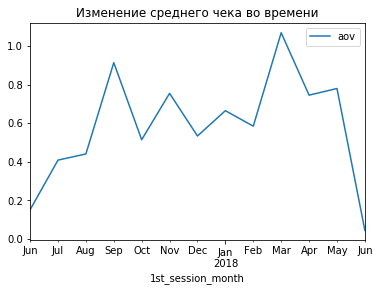

In [113]:
orders_grouped_by_cohorts.pivot_table(
index='1st_session_month',
#columns = 'lifetime',
values = 'aov',
aggfunc = 'sum'

).plot().set_title('Average invoice changes over time')

** We observe a abnormal growth  after September 2017, the peak value is in December 2017 (sale?), a regular drop in the 1st quarter of the year, a gradual decline and leveling off from April 2018.
Averages 8.99 units**


# Second month cohort trends
<a id = #second>
To calculate LTV, let's build a cohort report from the date of the first purchase. Find the number of buyers in each cohort. Next, add the month of the first purchase to the purchase information. We calculate the age of each cohort. After that, we add the number of customers in each cohort to the cohort report and calculate the revenue per customer. We build an age cohort report showing cumulative revenue per customer and visualize it using a heat map.

In [114]:
print(df['buy_ts'].describe())
df['revenue'].describe()

count                  761806
unique                  45990
top       2017-11-27 12:41:00
freq                      761
first     2017-06-01 00:10:00
last      2018-05-31 23:56:00
Name: buy_ts, dtype: object


count    761806.000000
mean          9.139077
std          38.477316
min           0.000000
25%           1.830000
50%           3.670000
75%           7.330000
max        2633.280000
Name: revenue, dtype: float64

In [115]:
df_merged = rr.merge(df_purchases, on = 'uid', how = 'left')
df_merged.columns

Index(['device', 'end_ts', 'source_id', 'date_x', 'uid', 'buy_ts_x', 'revenue',
       'year', 'month', 'day', 'week', 'cohort_name', 'session_duration_mins',
       'sess_mean', 'sess_weighted_avg', 'difference_x', 'end_month',
       'difference_sess', 'buy_ts_y', 'date_y', 'difference_y'],
      dtype='object')

In [116]:
df_merged = pd.DataFrame(df_merged.drop(columns = ['device', 'date_x', 'buy_ts_x', 'day', 'week', 'session_duration_mins',
       'sess_mean', 'sess_weighted_avg', 'difference_x', 'difference_sess', 'difference_y', 'date_y']))

In [117]:
df_merged['month_purchase'] = df_merged['buy_ts_y'].apply(lambda x: x.month)

In [118]:
df_merged.columns

Index(['end_ts', 'source_id', 'uid', 'revenue', 'year', 'month', 'cohort_name',
       'end_month', 'buy_ts_y', 'month_purchase'],
      dtype='object')

In [119]:
df_pivot = df_merged.pivot_table(
index = 'uid',
columns = 'month_purchase',
values = 'buy_ts_y',
aggfunc = 'first')

In [120]:
df_full = pd.merge(df_pivot, df_merged, on = 'uid', how = 'right')

In [121]:
second_month_cohorts = df_full.groupby(['cohort_name'])[2.0].agg('count')

Text(0.5, 1.0, 'Рост покупок второго месяца когорты')

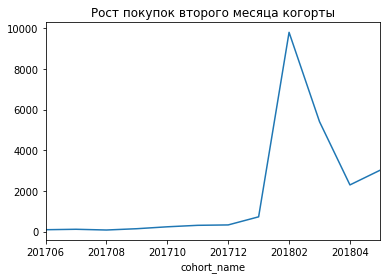

In [122]:
second_month_cohorts.plot().set_title('Orders growth of the 2nd month of orders')

**Preliminary conclusion. The growth from the second month was shown by the cohort “201802”, collected in February 2018. Then a drop and stabilization since April 2018.**

<a id='return'>Back to contents</a>

## LTV
<a id = #ltv>

Subtask: find out how LTV per customer changes by cohort. LTV is a cumulative metric. So, we need to calculate the average LTV by cohort for 6 months and include cohorts that have “lived” for at least 6 months in the calculation. Marginality must remain 100%.

We will find the number of buyers in each cohort. Next, add the month of the first purchase to the purchase information. We calculate the age of each cohort. After that, we add the number of customers in each cohort to the cohort report and calculate the revenue per customer. We build an age cohort report showing cumulative revenue per customer and visualize it using a heat map.

In [123]:
orders['age_cohort'] = ((orders['purchase_month'] - orders['1st_purchase_month']).dt.days / 30).astype('int')
cohort_sizes_ltv = orders.groupby('1st_purchase_month').agg({'uid':'nunique'})
cohort_sizes_ltv.columns = ['cohort_size']

In [124]:
orders_coh_ltv = orders.groupby(['1st_purchase_month', 'age_cohort']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
orders_coh_ltv = orders_coh_ltv.join(cohort_sizes_ltv, on='1st_purchase_month')
orders_coh_ltv['ltv'] = orders_coh_ltv['revenue'] / orders_coh_ltv['cohort_size']
orders_coh_ltv['revenue_per_user'] = orders_coh_ltv['revenue'] / orders_coh_ltv['uid']

In [125]:
mrg = 1 #Marginality. Multiplying by 1 will lead to the same output

In [126]:
ltv = orders_coh_ltv.pivot_table(
index = '1st_purchase_month',
columns = 'age_cohort',
values = 'ltv',
aggfunc = 'mean')

In [127]:
ltv

age_cohort,0,1,2,3,4,5,6,7,8,9,10,11
1st_purchase_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.950440,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.141820,0.161232,0.147145,0.155673,NaN
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540,0.210664,0.405007,0.292212,0.187978,NaN,NaN
2017-09-01,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067,0.701608,0.243150,0.184006,NaN,NaN,NaN
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816,0.115470,NaN,NaN,NaN,NaN
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,0.260374,0.925097,1.065275,0.312930,0.338047,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,0.599039,NaN,0.142778,0.062698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.435262,0.078515,0.074144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
orders['age_cohort'] = orders['age_cohort']
orders['age_cohort'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [129]:
ltv = ltv.cumsum(axis = 1)

In [130]:
ltv = ltv.reset_index()
ltv = ltv.set_index('1st_purchase_month')

Text(0.5, 1, 'LTV по когортам')

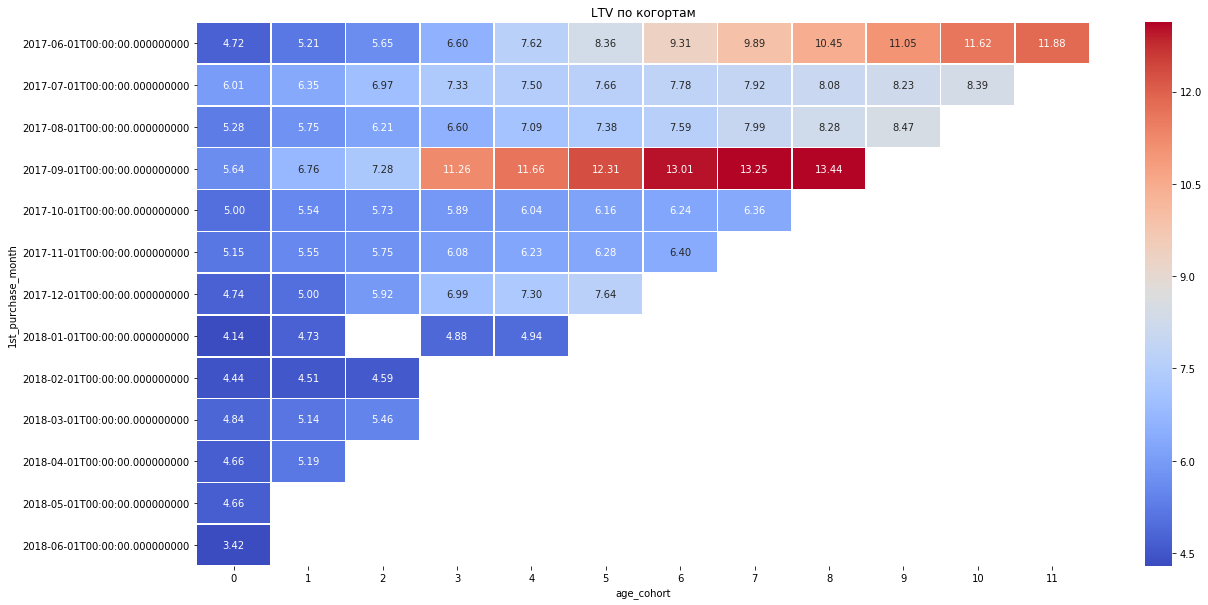

In [131]:
fig, ax = plt.subplots(figsize=(20,10))
sns.color_palette("rocket")
sns.heatmap(ltv, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm', robust=True).set_title('LTV by cohorts')



**September 2017 cohort attracts our attention**

In [132]:
ltv.mean().mean()

8.09109314433352

## ROMI
<a id = #romi>

Marketing expenses: we will need to find out how spending is distributed by source and visualize changes in metrics over time.
Customer acquisition costs: we will calculate the average CAC per buyer for the entire project and for each traffic source.

ROMI by source: we will compare the payback over the life periods of the cohorts. Clients coming from different sources => different LTV.


Supplementary: add a plot of total costs for all sources. This is necessary in order to assess whether the dynamics of changes in total costs correlqate with the dynamics of changes in costs for each source.
`(costs.pivot_table(index='costs_month', columns='source_id', values='costs', aggfunc='sum')`
      `.plot`
      `.area(???))`
`plt.show()`

In [133]:
costs_.columns

Index(['source_id', 'dt', 'costs'], dtype='object')

In [134]:
costs_total = costs_['costs'].sum()
print('Marketing investment summ {} units.'.format(costs_total))


Суммарные расходы на маркетинг составляют 329131.62 у.е.


In [135]:
print(costs_.columns)
costs_['dt'] = pd.to_datetime(costs_['dt'], format='%Y-%m-%d %H:%M:%S')

Index(['source_id', 'dt', 'costs'], dtype='object')


,device,end_ts,source_id,date,uid,buy_ts,revenue,year,month,day,week,cohort_name,session_duration_mins,sess_mean,sess_weighted_avg
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:25:00,2.33,2018,5,20,20,201805,24.0,7678364235770217472,0.006509
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09 20:25:00,2.33,2018,3,9,10,201803,28.0,7631815818556122112,0.006164
6,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-04 12:46:00,2.44,2017,9,3,35,201709,1.0,7807900956213769216,0.007391
7,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 00:01:00,1.53,2017,9,3,35,201709,1.0,7807900956213769216,0.007391
8,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 19:16:00,1.53,2017,9,3,35,201709,1.0,7807900956213769216,0.007391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023772,desktop,2017-12-04 12:50:00,3,2017-12-04 12:42:00,6752020629696526518,2017-12-04 12:46:00,4.15,2017,12,4,49,201712,8.0,7486737539215860736,0.005324
1023776,desktop,2017-11-20 23:44:00,4,2017-11-20 23:33:00,11750532881998794555,2017-11-20 23:43:00,3.67,2017,11,20,47,201711,11.0,7866003394987435008,0.004986
1023794,touch,2017-11-29 20:48:00,4,2017-11-29 20:27:00,11202626539189016002,2017-11-29 20:33:00,3.05,2017,11,29,48,201711,21.0,7548531982666362880,0.004785
1023808,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-23 21:16:00,0.49,2018,4,23,17,201804,8.0,7486737539215860736,0.006401


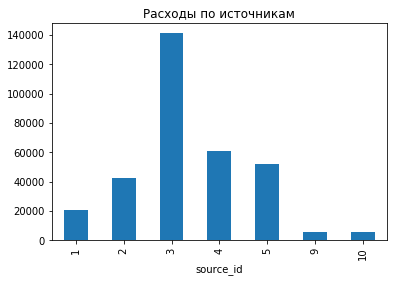

In [136]:
costs_['year'] = costs_['dt'].apply(lambda x: x.year)
costs_['month'] = costs_['dt'].apply(lambda x: x.month)
costs_['month_year'] = costs_['year'].astype(str) + costs_['month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
costs_by_sources = costs_.groupby(['source_id'])['costs'].sum()
costs_by_sources.plot(kind='bar').set_title('Investment per sources')
df.rename(columns = {'source_traffic':'source_id'})

** Expenses for Source number 3 are max**

In [137]:
costs_monthly = costs_.pivot_table(
index = 'month',
columns = 'source_id',
values = 'costs',
aggfunc = 'sum'

)

Text(0.5, 1.0, 'Расходы по источникам c динамикой изменения расходов по источнику')

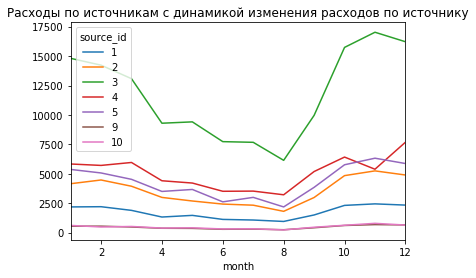

In [138]:
costs_monthly.plot().set_title('Costs by source with dynamics of changes in costs by source')

** It can be concluded that the dynamics of spending is the same.**

Next step

Calculate the average CAC per buyer for the entire project and for each traffic source. 


Calculate ROMI by source cohort. Compare the payback for the same periods of life of the cohorts.

In [139]:
#orders_['purchqse_month'] = orders_['buy_ts'].astype('datetime64[M]')

In [140]:
buyers = orders.groupby('uid').agg({'purchase_month': 'min'}).rename(columns = {'buy_ts': 'first_order_dt'}).reset_index()
buyers = buyers.merge(visits_.sort_values(by = 'start_ts').groupby('uid').agg({'source_id': 'first'}).reset_index(), 
                      on = 'uid', how = 'left')

In [141]:
buyers

,uid,purchase_month,source_id
0,313578113262317,2018-01-01,2
1,1575281904278712,2017-06-01,10
2,2429014661409475,2017-10-01,3
3,2464366381792757,2018-01-01,5
4,2551852515556206,2017-11-01,5
...,...,...,...
36518,18445147675727495770,2017-11-01,5
36519,18445407535914413204,2017-09-01,3
36520,18445601152732270159,2018-03-01,2
36521,18446156210226471712,2018-02-01,3


In [142]:
buyers_daily = buyers.groupby(['source_id', 'purchase_month']).agg({'uid': 'count'}).reset_index()

In [143]:
buyers_daily.rename(columns={'uid': 'n_buyers'}, inplace = True)
buyers_daily

,source_id,purchase_month,n_buyers
0,1,2017-06-01,190
1,1,2017-07-01,160
2,1,2017-08-01,113
3,1,2017-09-01,227
4,1,2017-10-01,340
...,...,...,...
81,10,2018-01-01,92
82,10,2018-02-01,123
83,10,2018-03-01,186
84,10,2018-04-01,107


In [144]:
costs_['dt'] = pd.to_datetime(costs_['dt'], format='%Y-%m-%d %H:%M:%S')

In [145]:
buyers_daily['purchase_month'] = pd.to_datetime(buyers_daily['purchase_month'], format='%Y-%m-%d %H:%M:%S')

In [146]:
buyers_daily

,source_id,purchase_month,n_buyers
0,1,2017-06-01,190
1,1,2017-07-01,160
2,1,2017-08-01,113
3,1,2017-09-01,227
4,1,2017-10-01,340
...,...,...,...
81,10,2018-01-01,92
82,10,2018-02-01,123
83,10,2018-03-01,186
84,10,2018-04-01,107


In [147]:
costs_ = pd.merge(buyers_daily, costs_, left_on=['source_id', 'purchase_month'], right_on=['source_id', 'dt'])

In [148]:
costs_

,source_id,purchase_month,n_buyers,dt,costs,year,month,month_year
0,1,2017-06-01,190,2017-06-01,75.20,2017,6,201706
1,1,2017-07-01,160,2017-07-01,5.80,2017,7,201707
2,1,2017-08-01,113,2017-08-01,44.65,2017,8,201708
3,1,2017-09-01,227,2017-09-01,40.28,2017,9,201709
4,1,2017-10-01,340,2017-10-01,57.14,2017,10,201710
...,...,...,...,...,...,...,...,...
72,10,2017-12-01,85,2017-12-01,13.34,2017,12,201712
73,10,2018-01-01,92,2018-01-01,28.99,2018,1,201801
74,10,2018-02-01,123,2018-02-01,32.07,2018,2,201802
75,10,2018-03-01,186,2018-03-01,9.86,2018,3,201803


In [149]:
costs_['costs_per_buyer'] = costs_['costs']/costs_['n_buyers']
display(costs_.sort_values(by = ['month']))


,source_id,purchase_month,n_buyers,dt,costs,year,month,month_year,costs_per_buyer
51,5,2018-01-01,633,2018-01-01,149.29,2018,1,201801,0.235845
18,2,2018-01-01,292,2018-01-01,113.13,2018,1,201801,0.387432
73,10,2018-01-01,92,2018-01-01,28.99,2018,1,201801,0.315109
29,3,2018-01-01,1006,2018-01-01,364.64,2018,1,201801,0.362465
40,4,2018-01-01,1032,2018-01-01,92.45,2018,1,201801,0.089583
...,...,...,...,...,...,...,...,...,...
28,3,2017-12-01,1317,2017-12-01,452.52,2017,12,201712,0.343599
50,5,2017-12-01,771,2017-12-01,216.67,2017,12,201712,0.281025
72,10,2017-12-01,85,2017-12-01,13.34,2017,12,201712,0.156941
17,2,2017-12-01,381,2017-12-01,193.39,2017,12,201712,0.507585


In [150]:
u = costs_.pivot_table(index=['month'], columns='source_id', values='costs_per_buyer', aggfunc='mean').fillna(0)

Text(0.5, 1, 'Динамика стоимости привлечения клиента')

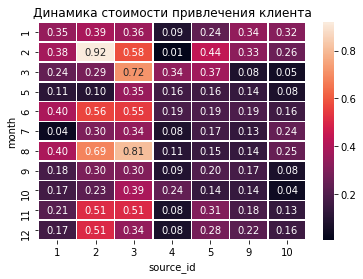

In [151]:
sns.heatmap(u, annot=True, fmt=".2f", linewidths=.5).set_title('CAC dynamics')


**Note. The second and third sources are expensive - according to them, attraction is more expensive.**

In [152]:
cac_sources = costs_.pivot_table(
index='source_id',values='costs_per_buyer', aggfunc='sum')

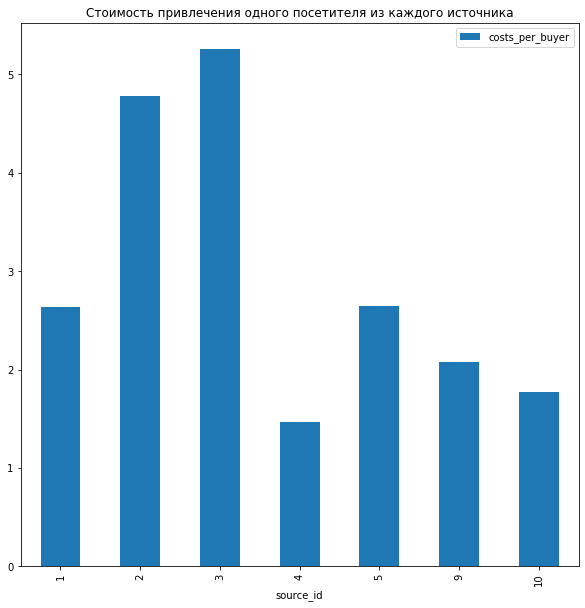

In [153]:
cac_sources.plot(kind='bar', figsize=(10,10), title='The cost of attracting one visitor from each source')



**The second and third sources are the most expensive (different visualization)**

In [154]:
display(orders.head(2))
orders_coh_ltv.head(2)

,buy_ts,revenue,uid,1st_purch_ts,1st_activity,1st_source,1st_purchase_month,1st_session_month,purchase_month,lifetime,age_cohort
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,1,2017-06-01,2017-06-01,2017-06-01,1,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,2,2017-06-01,2017-06-01,2017-06-01,1,0


,1st_purchase_month,age_cohort,revenue,uid,cohort_size,ltv,revenue_per_user
0,2017-06-01,0,9557.49,2023,2023,4.724414,4.724414
1,2017-06-01,1,981.82,61,2023,0.485329,16.095410


In [155]:
i = orders_coh_ltv.drop(['revenue', 'cohort_size', 'ltv'], axis=1).groupby(['uid'])['revenue_per_user'].sum()


In [156]:
orders_coh_ltv

,1st_purchase_month,age_cohort,revenue,uid,cohort_size,ltv,revenue_per_user
0,2017-06-01,0,9557.49,2023,2023,4.724414,4.724414
1,2017-06-01,1,981.82,61,2023,0.485329,16.095410
2,2017-06-01,2,885.34,50,2023,0.437637,17.706800
3,2017-06-01,3,1931.30,54,2023,0.954671,35.764815
4,2017-06-01,4,2068.58,88,2023,1.022531,23.506591
...,...,...,...,...,...,...,...
72,2018-03-01,2,1114.87,58,3533,0.315559,19.221897
73,2018-04-01,0,10600.69,2276,2276,4.657597,4.657597
74,2018-04-01,1,1209.92,69,2276,0.531599,17.535072
75,2018-05-01,0,13925.76,2988,2988,4.660562,4.660562


In [157]:
df_all = pd.merge(buyers, costs_, left_on = 'source_id', right_on = 'source_id').merge(orders, on = 'uid')

In [158]:
df_all

,uid,purchase_month_x,source_id,purchase_month_y,n_buyers,dt,costs,year,month,month_year,...,buy_ts,revenue,1st_purch_ts,1st_activity,1st_source,1st_purchase_month,1st_session_month,purchase_month,lifetime,age_cohort
0,313578113262317,2018-01-01,2,2017-06-01,235,2017-06-01,132.56,2017,6,201706,...,2018-01-03 21:51:00,0.55,2018-01-03 21:51:00,2017-09-18 22:49:00,2,2018-01-01,2017-09-01,2018-01-01,5,0
1,313578113262317,2018-01-01,2,2017-07-01,208,2017-07-01,61.77,2017,7,201707,...,2018-01-03 21:51:00,0.55,2018-01-03 21:51:00,2017-09-18 22:49:00,2,2018-01-01,2017-09-01,2018-01-01,5,0
2,313578113262317,2018-01-01,2,2017-08-01,123,2017-08-01,84.42,2017,8,201708,...,2018-01-03 21:51:00,0.55,2018-01-03 21:51:00,2017-09-18 22:49:00,2,2018-01-01,2017-09-01,2018-01-01,5,0
3,313578113262317,2018-01-01,2,2017-09-01,221,2017-09-01,65.27,2017,9,201709,...,2018-01-03 21:51:00,0.55,2018-01-03 21:51:00,2017-09-18 22:49:00,2,2018-01-01,2017-09-01,2018-01-01,5,0
4,313578113262317,2018-01-01,2,2017-10-01,396,2017-10-01,90.53,2017,10,201710,...,2018-01-03 21:51:00,0.55,2018-01-03 21:51:00,2017-09-18 22:49:00,2,2018-01-01,2017-09-01,2018-01-01,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554549,18433563955913283641,2017-11-01,9,2017-12-01,121,2017-12-01,26.85,2017,12,201712,...,2017-11-24 13:15:00,1.69,2017-11-24 13:15:00,2017-11-24 12:47:00,9,2017-11-01,2017-11-01,2017-11-01,1,0
554550,18433563955913283641,2017-11-01,9,2018-01-01,80,2018-01-01,27.23,2018,1,201801,...,2017-11-24 13:15:00,1.69,2017-11-24 13:15:00,2017-11-24 12:47:00,9,2017-11-01,2017-11-01,2017-11-01,1,0
554551,18433563955913283641,2017-11-01,9,2018-02-01,84,2018-02-01,27.78,2018,2,201802,...,2017-11-24 13:15:00,1.69,2017-11-24 13:15:00,2017-11-24 12:47:00,9,2017-11-01,2017-11-01,2017-11-01,1,0
554552,18433563955913283641,2017-11-01,9,2018-03-01,161,2018-03-01,13.13,2018,3,201803,...,2017-11-24 13:15:00,1.69,2017-11-24 13:15:00,2017-11-24 12:47:00,9,2017-11-01,2017-11-01,2017-11-01,1,0


In [159]:
i = df_all.pivot_table(
index = ['uid'],
values = ['costs_per_buyer', 'revenue', '1st_purchase_month'],
aggfunc = ({'costs_per_buyer':'sum', 'revenue':'sum', '1st_purchase_month':'first'})
)

In [160]:
i['romi'] = (i['revenue'] - i['costs_per_buyer'])/ i['costs_per_buyer']
i.columns

Index(['1st_purchase_month', 'costs_per_buyer', 'revenue', 'romi'], dtype='object')

In [161]:
buyers

,uid,purchase_month,source_id
0,313578113262317,2018-01-01,2
1,1575281904278712,2017-06-01,10
2,2429014661409475,2017-10-01,3
3,2464366381792757,2018-01-01,5
4,2551852515556206,2017-11-01,5
...,...,...,...
36518,18445147675727495770,2017-11-01,5
36519,18445407535914413204,2017-09-01,3
36520,18445601152732270159,2018-03-01,2
36521,18446156210226471712,2018-02-01,3


In [162]:
buyers2 = buyers.copy()
buyers2.reset_index(inplace=True)
display(i.head(2))
buyers2

,1st_purchase_month,costs_per_buyer,revenue,romi
uid,,,,
313578113262317,2018-01-01,4.782995,6.05,0.264898
1575281904278712,2017-06-01,3.535699,33.55,8.488929


,index,uid,purchase_month,source_id
0,0,313578113262317,2018-01-01,2
1,1,1575281904278712,2017-06-01,10
2,2,2429014661409475,2017-10-01,3
3,3,2464366381792757,2018-01-01,5
4,4,2551852515556206,2017-11-01,5
...,...,...,...,...
36518,36518,18445147675727495770,2017-11-01,5
36519,36519,18445407535914413204,2017-09-01,3
36520,36520,18445601152732270159,2018-03-01,2
36521,36521,18446156210226471712,2018-02-01,3


In [163]:
y = pd.merge(i, buyers2, left_on = 'uid', right_on = 'uid')
y

,uid,1st_purchase_month,costs_per_buyer,revenue,romi,index,purchase_month,source_id
0,313578113262317,2018-01-01,4.782995,6.05,0.264898,0,2018-01-01,2
1,1575281904278712,2017-06-01,3.535699,33.55,8.488929,1,2017-06-01,10
2,2429014661409475,2017-10-01,5.262271,806.63,152.285527,2,2017-10-01,3
3,2464366381792757,2018-01-01,2.648637,26.84,9.133513,3,2018-01-01,5
4,2551852515556206,2017-11-01,5.297274,120.89,21.821171,4,2017-11-01,5
...,...,...,...,...,...,...,...,...
36517,18445147675727495770,2017-11-01,2.648637,33.55,11.666892,36518,2017-11-01,5
36518,18445407535914413204,2017-09-01,15.786813,9.68,-0.386830,36519,2017-09-01,3
36519,18445601152732270159,2018-03-01,4.782995,46.42,8.705217,36520,2018-03-01,2
36520,18446156210226471712,2018-02-01,5.262271,107.58,19.443645,36521,2018-02-01,3


In [164]:
y2 = y.pivot_table(
index = 'source_id',
values = 'romi',
aggfunc = 'sum',
columns = 'purchase_month'

).pct_change().fillna(0)

Text(0.5, 1, 'Разница ROMI в динамике')

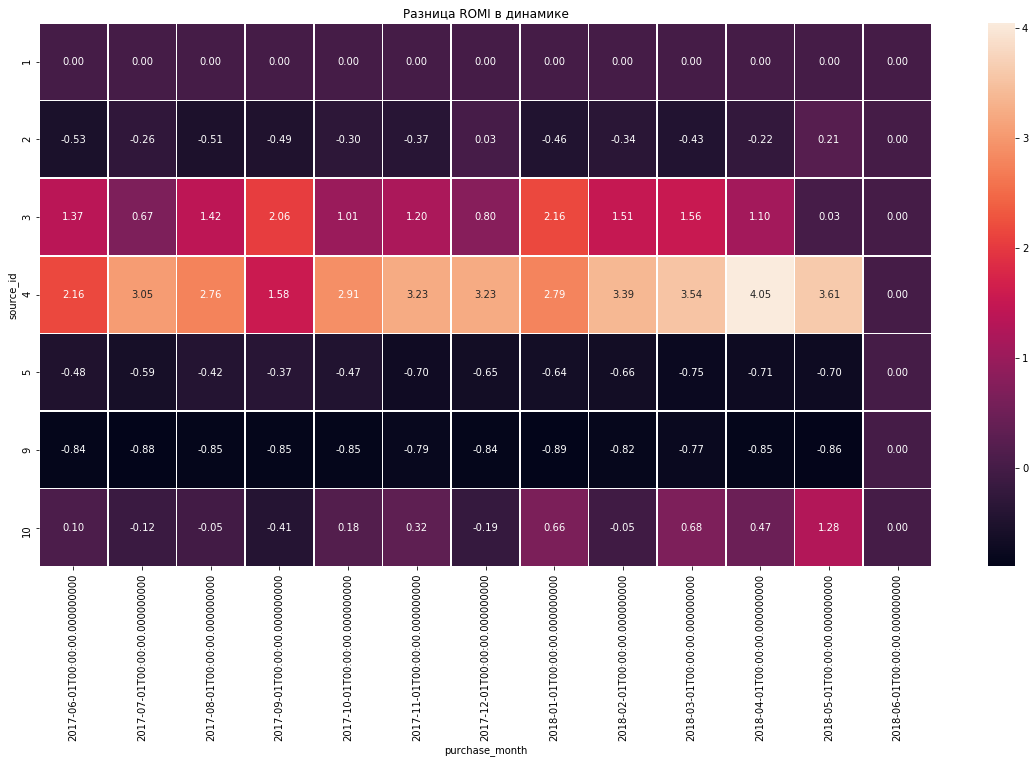

In [165]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(y2, annot=True, fmt=".2f", linewidths=.5).set_title('Difference of ROMI in dynamics')


** Preliminary conclusion. The fourth source shows a consistently high ROMI, even if we only visualize the changes (the difference from the previous month on the chart). 
According to the ROMI metric (the ratio of marketing investments and income), the ranking of sources:
1 source
2 source
9 source
5 source
4 source
Closes 3 traffic sources**

# Conclusions
<a id = 'conclusions'>


There were no repetitions in the original data, but the temporal data were outside the scope of the study. But each user could make several sessions. The marketing spend data is missing information on several traffic sources. The analysis was carried out without them.
 Connectivity devices—PC and mobile—are unevenly separated. PC has an advantage => you need to make an adaptive layout for mobile devices.

Sources bring **traffic** in different ways: number 1, 2 and 5 are in the lead.

User growth depends on holidays and weekends. Illustrates the fall on December 31, 2017. On this day, you can lower your bids in advertising systems to minus 100.
Since August 2017, there has been an increase in both weekly and monthly growth.

**Custom Metrics**
The average is 1 session per day, considering cohorts. If for all - 4.5 times. The weighted average session length is half a minute.

**Retention**
August and September 2018 cohorts show the best result
Average cohort lifespan: 197 days, maximum 365.

**Audience warm-up**
For six months, on average, they buy 14 times. Ponder 2 months on average. 75% buy within an hour.

**Expertise needed** Of interest is the September 2017 cohort. It is necessary to find data on users and conduct a targeted analysis of the cohort and the conditions of their purchasing power. Highest LTV!

**Average check**
We observe a jump and growth after September 2017, the peak value is in December 2017 (sale?), a natural fall in the 1st quarter of the year, a gradual decline and leveling off from April 2018
Averages **0.09 c.u.**



**Trends of the second month**
The growth of purchases from the second month was especially shown by the cohort “201802”, collected in February 2018. Then the fall and stabilization since April 2018

**LTV**
Preliminary conclusion. LTV is good for 1,2,5 traffic sources.
Average LTV - 8 c.u.
**Sources:**
In terms of profitability and LTV, 1,2 and 5 are the most productive. The third source is the most costly.

**According to the ROMI metric (the ratio of marketing injections and income), ranking of sources: 1st source 9th source 2nd source 5th source 4th source Closes the 3rd traffic source**
The third source is the most used and the most costly. The fourth one shows a consistently high ROMI, even if we only visualize the changes (on the chart, the difference from the previous month)

Without data on missing traffic sources, it is impossible to draw full conclusions.